# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Model](#5.4_Load_Model)
  * [5.5 Load Data](#5.5_Load_Data)
  * [5.6 Refit Model On All Available Data (excluding Big Mountain)](#5.6_Refit_Model_On_All_Available_Data_(excluding_Big_Mountain))
  * [5.7 Calculate Expected Big Mountain Ticket Price From The Model](#5.7_Calculate_Expected_Big_Mountain_Ticket_Price_From_The_Model)
  * [5.8 Big Mountain Resort In Market Context](#5.8_Big_Mountain_Resort_In_Market_Context)
    * [5.8.1 Ticket price](#5.8.1_Ticket_price)
    * [5.8.2 Vertical drop](#5.8.2_Vertical_drop)
    * [5.8.3 Snow making area](#5.8.3_Snow_making_area)
    * [5.8.4 Total number of chairs](#5.8.4_Total_number_of_chairs)
    * [5.8.5 Fast quads](#5.8.5_Fast_quads)
    * [5.8.6 Runs](#5.8.6_Runs)
    * [5.8.7 Longest run](#5.8.7_Longest_run)
    * [5.8.8 Trams](#5.8.8_Trams)
    * [5.8.9 Skiable terrain area](#5.8.9_Skiable_terrain_area)
  * [5.9 Modeling scenarios](#5.9_Modeling_scenarios)
    * [5.9.1 Scenario 1](#5.9.1_Scenario_1)
    * [5.9.2 Scenario 2](#5.9.2_Scenario_2)
    * [5.9.3 Scenario 3](#5.9.3_Scenario_3)
    * [5.9.4 Scenario 4](#5.9.4_Scenario_4)
  * [5.10 Summary](#5.10_Summary)
  * [5.11 Further work](#5.11_Further_work)


## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, we now take our model for ski resort ticket price and leverage it to gain some insights into what price Big Mountain's facilities might actually support as well as explore the sensitivity of changes to various resort parameters. Note that this relies on the implicit assumption that all other resorts are largely setting prices based on how much people value certain facilities. Essentially this assumes prices are set by a free market.

We can now use our model to gain insight into what Big Mountain's ideal ticket price could/should be, and how that might change under various scenarios.

In [2]:
#okay cool so we're gonna see what Big Mountain in Montana can actually charge based on what others are doing and their
#parameters. We're gonna "explore the sensitivity of changes to arious resort parameters" - so that doesn't mean we're
#gonna like literally change the parameters and see what happens to the price, cuz obviously we don't know what would
#happen. I guess it just means explore the trends / relationships b/w certain params and price, maybe some do have a
#direct linear correlation, maybe others have no correlation, and maybe others have a non-linear correlation

#and it's saying the assumptions are free market conditions, i.e. that the price is being determined by supply &
#demand, i.e. by how much ppl value certain things (params)

#and always remember, we can never have ALL the data, we can only get a snapshot/representation of it
#and we can never know how ppl truly feel about something, even if there's data on it / they answer survey questions

## 5.3 Imports<a id='5.3_Imports'></a>

In [3]:
import pandas as pd
import numpy as np
import os
import pickle  #?
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate

## 5.4 Load Model<a id='5.4_Load_Model'></a>

In [4]:
# This isn't exactly production-grade, but a quick check for development
# These checks can save some head-scratching in development when moving from
# one python environment to another, for example

expected_model_version = '1.0'  #what was this supposed to represent again?
model_path = '../models/ski_resort_pricing_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

Expected model version doesn't match version loaded


In [5]:
# okay cool so these are just version checkers to warn someone in the beginning that something may be off / not be what
# they expect

## 5.5 Load Data<a id='5.5_Load_Data'></a>

In [6]:
ski_data = pd.read_csv('../data/ski_data_step3_features.csv')

In [7]:
#oh once again i gotta change it up to match what they're expecting:

ski_data = ski_data[ski_data.yearsOpen < 1000]

ski_data.dropna(subset=['AdultWeekend'], inplace=True)

ski_data.reset_index(drop=True, inplace=True)

In [8]:
big_mountain = ski_data[ski_data.Name == 'Big Mountain Resort']

In [9]:
big_mountain.T

,124
Name,Big Mountain Resort
Region,Montana
state,Montana
summit_elev,6817
vertical_drop,2353
base_elev,4464
trams,0
fastSixes,0
fastQuads,3
quad,2


In [10]:
#there we go, aH now iA should be good

## 5.6 Refit Model On All Available Data (excluding Big Mountain)<a id='5.6_Refit_Model_On_All_Available_Data_(excluding_Big_Mountain)'></a>

This next step requires some careful thought. We want to refit the model using all available data. But should we include Big Mountain data? On the one hand, we are _not_ trying to estimate model performance on a previously unseen data sample, so theoretically including Big Mountain data should be fine. One might first think that including Big Mountain in the model training would, if anything, improve model performance in predicting Big Mountain's ticket price. But here's where our business context comes in. The motivation for this entire project is based on the sense that Big Mountain needs to adjust its pricing. One way to phrase this problem: we want to train a model to predict Big Mountain's ticket price based on data from _all the other_ resorts! We don't want Big Mountain's current price to bias this. We want to calculate a price based only on its competitors.

In [11]:
#interesting, so when we want to predict/set one or a specific group of values, then the question is - do we include
#that/those in the TEST set, or do we leave that out and go to it independently/separately, after having worked on our
#model and testing it and being happy with it, and only then applying it to the target?

#cuz remember, the goal is to SET a fair price for Big Mountain.... ****NOT**** predict what it currently is!
#we don't care that much what it currently is -- the whole point is to set it RIGHT in light of what others in the
#industry are / what the free market is doing!

#aH that's exactly what they wrote too, which I came up w/ aH before reading it :)

In [12]:
#okay so our X's are all the features, except price, and excluding Big Mountain
#and our y's, the thing we're tryna predict, are the $prices ('AdultWeekend'), excluding of course Big Mountain's

#okay so here's what 'model' is:

# model_path = '../models/ski_resort_pricing_model.pkl'
# if the model_path exists, it's set to equal 'model'

# so:

# model = model_path = 'ski_resort_pricing_model.pkl' >> which is our set of dev/developer params!
# this is our 'best_model' which is 'rf_grid_cv.best_estimator_'
#which was: GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

# so the X set/df is all the rows except Big Mountain, and all the columns for those except price...
# but wait a minute - HOW DOES IT KNOW NOT TO INCLUDE THE PRICE COLUMN?!
# like yes it's set to use the columns 'X_columns', but where does that come from and how does it know not to use
# the price column???

# oh, so remem in 'model', which we defined at the end of the last unit, we set the 'X_columns' param to equal the
# columns of X_train, which we THEN/THERE defined to be all the columns of ski_data EXCEPT AdultWeekend!!!

# and then the y set is of course just one column - the price$ - AdultWeekend, and for all the rows except Big Mountain!

X = ski_data.loc[ski_data.Name != "Big Mountain Resort", model.X_columns]
y = ski_data.loc[ski_data.Name != "Big Mountain Resort", 'AdultWeekend']

In [13]:
len(X), len(y)

(276, 276)

In [14]:
model.fit(X, y)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', None),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=69, random_state=47))])

In [15]:
#here we run the model multiple times to see how the negative MAE fares across multiple trials

#and again, 'model' is our latest, best, random forest model from the end of unit 4:
# rf_grid_cv.best_estimator_
#the best_estimator_ means store the combo of params that gave us the highest score, like in terms of prediction accuracy

cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

#this is like exactly what we did before, in end unit 4, no?:
# rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [16]:
#oh wait, but so now, this time, as opposed to last time, WE'RE NOT SPLITTING INTO TRAINING & TEST GROUPS!!!
#cuz we've already done that! and that's why we have that best rf model stored!
#so now, we're, satisfied w/ our model/best one yet/so far, and so thus applying it to / expanding it to train on /
#training it on the ENTIRE dataset MINUS/EXCEPT OUR TARGET - BIG MOUNTAIN!

In [17]:
#the function we made above includes a 'test_scores' column using the type of scoring we specified/requested, which was
#neg MAE, and so that's what these are!
cv_results['test_score']

array([-12.01641563,  -9.27669829, -11.56562846,  -8.16083531,
       -11.01279842])

In [18]:
#very close to template

In [19]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(10.406475221155656, 1.4575641807727837)

In [20]:
#again, super duper close

These numbers will inevitably be different to those in the previous step that used a different training data set. They should, however, be consistent. It's important to appreciate that estimates of model performance are subject to the noise and uncertainty of data!

In [21]:
#oh yeah! so the reason they're different from unit 4's is because this uses the ENTIRE dataset (minus Big M) as the
#training set whereas that only used 70% (and was also minus BM)

## 5.7 Calculate Expected Big Mountain Ticket Price From The Model<a id='5.7_Calculate_Expected_Big_Mountain_Ticket_Price_From_The_Model'></a>

In [22]:
#okay so now we're homing in on JUST BM
#pinpoint just its row and taking as the X predictors all its columns/features except for of course price - the thing
#we're tryna predict!

#and then of course the y is that price iA we'll predict
X_bm = ski_data.loc[ski_data.Name == "Big Mountain Resort", model.X_columns]
y_bm = ski_data.loc[ski_data.Name == "Big Mountain Resort", 'AdultWeekend']

In [23]:
X_bm

,summit_elev,vertical_drop,base_elev,trams,fastSixes,fastQuads,quad,triple,double,surface,...,resorts_per_100kcapita,resorts_per_100ksq_mile,resort_skiable_area_ac_state_ratio,resort_days_open_state_ratio,resort_terrain_park_state_ratio,resort_night_skiing_state_ratio,total_chairs_runs_ratio,total_chairs_skiable_ratio,fastQuads_runs_ratio,fastQuads_skiable_ratio
124,6817,2353,4464,0,0,3,2,6,0,3,...,1.122778,8.161045,0.140121,0.129338,0.148148,0.84507,0.133333,0.004667,0.028571,0.001


In [24]:
y_bm

124    81.0
Name: AdultWeekend, dtype: float64

In [25]:
y_bm.values

array([81.])

In [26]:
y_bm.values.item()

81.0

In [27]:
#ahh okay, so the above explains what is going on here / what these things mean. see below

In [28]:
model.predict(X_bm)

array([96.31869565])

In [29]:
#so we're storing as a variable / telling it to use our best rf model to predict the price using the X_bm we just defined
#note, as learned above, using '.item()' is SIMPLY to nicely isolate the single number that's trapped/wrapped in an
#array brackets and extra/neous info and cherry-pick out just the single number itself! for clean easy viewing
bm_pred = model.predict(X_bm).item()

#but how does it know what it's predicting? like how does it know to use all those like 32 params and use it to come
#up w/ the target price number? like doesn't it have to know the relationships between the training set's same set of
#these 32 variables and then their prices?


#ohhh yeah, so that's already all baked deep into the model, if you look back / trace back its roots/history!

#that's why it was so good to do that intense, packed building package work earlier, cuz now it's as simple as just
#calling on one simple word/variable, representing all of it - MODEL!


In [30]:
bm_pred

96.31869565217391

In [31]:
#there we go! that's the predicted price! i.e., based on what everyone else is doing given their offerings, this is
#what Big Mountain should charge, i.e. the FAIR MARKET PRICE

#by contrast, this is what they were charging:

In [32]:
#as seen above, all this is simply doing is isolating down to the number itself; don't get confused / overwhelmed;
#nothing fancy is happening here

y_bm = y_bm.values.item()
y_bm

81.0

In [ ]:
# wow! so subhanaAllah they were charging $15 too less!/UNDERcharging / selling themselves short by $15 per person!!!
#that's almost 20% short/under!!!!

In [34]:
print(f'Big Mountain Resort modelled price is ${bm_pred:.2f}, actual price is ${y_bm:.2f}.')
print(f'Even with the expected mean absolute error of ${mae_mean:.2f}, this suggests there is room for an increase.')

Big Mountain Resort modelled price is $96.32, actual price is $81.00.
Even with the expected mean absolute error of $10.41, this suggests there is room for an increase.


In [40]:
#our number here is slightly more than template, but again, it's gonna be slightly different w/ each run. we could
#run it like 5 times and take the average, right?

#cross_validate(model,X, cv=5)

#....^No.... at least not like this. not sure how you'd do it


######################################################################
##########################???QUESTION???##############################
######################################################################

In [ ]:
# and oh right, good point - to look at the MAE, which is about $10. so that's saying even if we're wrong and max out
# that mean error, we're STILL a few bucks above where they're at!!

This result should be looked at optimistically and doubtfully! The validity of our model lies in the assumption that other resorts accurately set their prices according to what the market (the ticket-buying public) supports. The fact that our resort seems to be charging that much less than what's predicted suggests our resort might be undercharging. 
But if ours is mispricing itself, are others? It's reasonable to expect that some resorts will be "overpriced" and some "underpriced." Or if resorts are pretty good at pricing strategies, it could be that our model is simply lacking some key data? Certainly we know nothing about operating costs, for example, and they would surely help.

In [ ]:
# right, so this assumes that OTHER resorts are basing their prices on features and market norms. but if everyone did that,
# #how could ANYONE set their prices, like who would go first, and HOW would they go first?? #headscratcher

#oh yeah, good point - maybe other resorts are mispricing themselves too cuz they don't know / maybe didn't base it off
#of what others were charging! or maybe only based it off of other SIMILAR groups. BASICALLY LOOKING AT ***COMPS***
# / NEAREST NEIGHBORS / ***CLUSTERS*** thru PCA!!!! that's maybe how these algorithms work!!! how many bedrooms, bathrooms, *newness* /
# wildcard, garage, yard size, neighborhood, etc etc. but like w/ those too, maybe they weren't basing it off of what
#others were going for!


#oh yeah, and that's a key point - about operating costs. of course this is a huge factor in any business's pricing
#strategy and we know NOTHING about this for ANY of our 

## 5.8 Big Mountain Resort In Market Context<a id='5.8_Big_Mountain_Resort_In_Market_Context'></a>

Features that came up as important in the modeling (not just our final, random forest model) included:
* vertical_drop
* Snow Making_ac
* total_chairs
* fastQuads
* Runs
* LongestRun_mi
* trams
* SkiableTerrain_ac

A handy glossary of skiing terms can be found on the [ski.com](https://www.ski.com/ski-glossary) site. Some potentially relevant contextual information is that vertical drop, although nominally the height difference from the summit to the base, is generally taken from the highest [_lift-served_](http://verticalfeet.com/) point.

In [ ]:
# okay so i think it's saying vertical drop is the distance b/w the highest and lowest 'lift-served' points,
# and 'lift-served' simply means the points/verticalities at which the lift drops off at?

It's often useful to define custom functions for visualizing data in meaningful ways. The function below takes a feature name as an input and plots a histogram of the values of that feature. It then marks where Big Mountain sits in the distribution by marking Big Mountain's value with a vertical line using `matplotlib`'s [axvline](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.axvline.html) function. It also performs a little cleaning up of missing values and adds descriptive labels and a title.

In [ ]:
# hey they copied me! this is the same idea of what i did earlier on w/ my plots and tables!

In [48]:
#Code task 1#
#Add code to the `plot_compare` function that displays a vertical, dashed line
#on the histogram to indicate Big Mountain's position in the distribution

#Hint: plt.axvline() plots a vertical line, its position for 'feature1'

#would be `big_mountain['feature1'].values, we'd like a red line, which can be

#specified with c='r', a dashed linestyle is produced by ls='--', (#'ls' = 'line style!')

#and it's nice to give it a slightly reduced alpha value, such as 0.8.

#Don't forget to give it a useful label (e.g. 'Big Mountain') so it's listed in the legend


def plot_compare(feat_name, description, state=None, figsize=(10, 5)):
#so remember, a function is like a food making kit, and it bundles all the ingredients together in the beginning,
#to lay it out for the recipe. so you're gonna hand it:  (explained below) the feature/column name, a description
#of that feature, the specific state (like Pennsylvania), and the fig_size that'll be used for plotting


#so this is gonna result in a histo of the feature for ALL resorts, including BM, and we're gonna mark it to see where
#it lies
    
    """Graphically compare distributions of features.
    
    Plot histogram of values for all resorts and reference line to mark
    Big Mountain's position.
    
    Arguments:
    feat_name - the feature column name in the data
    description - text description of the feature
    state - select a specific state (None for all states)
    figsize - (optional) figure size
    """
    
    plt.subplots(figsize=figsize)
    
    #okay so apparently there's this quirk w/ hist, described below, where it sometimes doesn't like NaNs
    # quirk that hist sometimes objects to NaNs, sometimes doesn't
    # filtering only for finite values tidies this up
    
    if state is None:
        ski_x = ski_data[feat_name]  #so if you DON'T specify a single state, this will just filter the ski_data down 
    else:                            #to just the column of the one specified feature and include ALL resorts/states
                                     #since you didn't filter so it won't subset any further
        ski_x = ski_data.loc[ski_data.state == state, feat_name]  #by contrast, if you DO specify a state, it'll take
    ski_x = ski_x[np.isfinite(ski_x)]                           #it a step further and subset not just for/to that column,
                                                                #but for that specific state!
    plt.hist(ski_x, bins=30)
    plt.axvline(x=big_mountain[feat_name].values, c='r', ls='--', alpha=0.8, label='Big Mountain')
    #so obvy this only applies if you're doing ALL resorts/states/not specifying or are doing JUST the state of Montana!
    
    #so we have to tell it which x do dash-the-dotted line vertical drawn on - so the x- point @which/=equal to Big Mountain's value of that specific/particular feature!
    #cool so we're not literally telling it to find the point/plot of Big Mountain and mark/highlight that, we got
    #creative, did a natural workaround - we said take the VALUE OF BIG MOUNTAIN AND SIMPLY MARK THAT VALUE BAR!!!
    plt.xlabel(description)
    plt.ylabel('frequency')
    plt.title(description + ' distribution for resorts in market share')
    plt.legend()

### 5.8.1 Ticket price<a id='5.8.1_Ticket_price'></a>

Look at where Big Mountain sits overall amongst all resorts for price and for just other resorts in Montana.

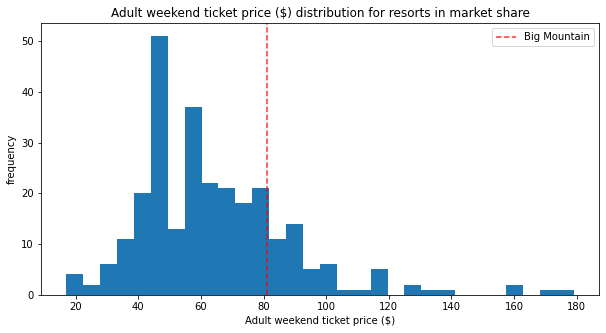

In [49]:
#okay sick. slick. so now we're gonna put this function to use and see where BM stands w/ price:

plot_compare('AdultWeekend', 'Adult weekend ticket price ($)')

In [ ]:
# okay cool so we can see it's a bit towards the higher end, althought there's def several one-off outliers that push
# way even further upstream

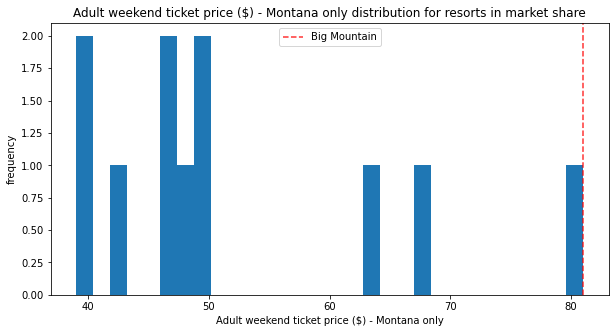

In [18]:
#now let's see how JUST Montana looks like and how Big Mountain stacks there
#btw MINE WAS WAY BETTER - I actually colored the BAR and was SPECIFIC TO BIG MOUNTAIN! plotted on that basis,
#i.e. one plot for EACH resort, NOT a bucketized histo!
#in this case, when just looking at one state, they bucketized in groups of 1's or 2's
plot_compare('AdultWeekend', 'Adult weekend ticket price ($) - Montana only', state='Montana')

In [ ]:
#ouch. so yeah, we saw this earlier - BM is by far the most expensive in Montana - AND WE'RE TRYNA TELL THEM TO CHARGE
#EVEN MORE! and remem, when we compared its features to other ones in Montana it offered WAY LESS!

### 5.8.2 Vertical drop<a id='5.8.2_Vertical_drop'></a>

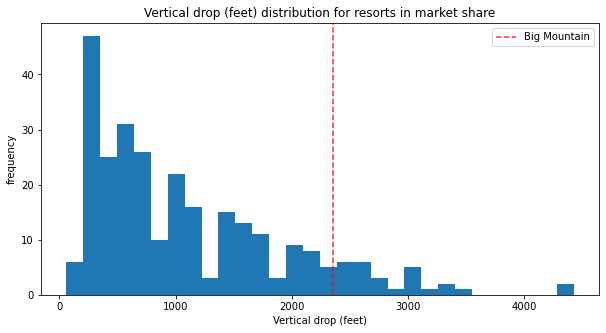

In [19]:
plot_compare('vertical_drop', 'Vertical drop (feet)')

In [50]:
#ah okay, so yeah you can go about these plots this way too, of doing histogram and bucketizing and doing frequency vs.
#value. but i like doing individual plots of each resort and make y-axis the actual value and order it descending

#but yeah, okay, vert drop is towards the higher side so it's putting its money where its mouth is

Big Mountain is doing well for vertical drop, but there are still quite a few resorts with a greater drop.

### 5.8.3 Snow making area<a id='5.8.3_Snow_making_area'></a>

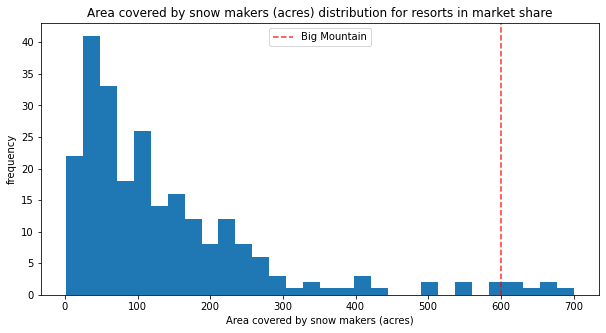

In [51]:
plot_compare('Snow Making_ac', 'Area covered by snow makers (acres)')

In [ ]:
# good job BM! top performer!

Big Mountain is very high up the league table of snow making area.

### 5.8.4 Total number of chairs<a id='5.8.4_Total_number_of_chairs'></a>

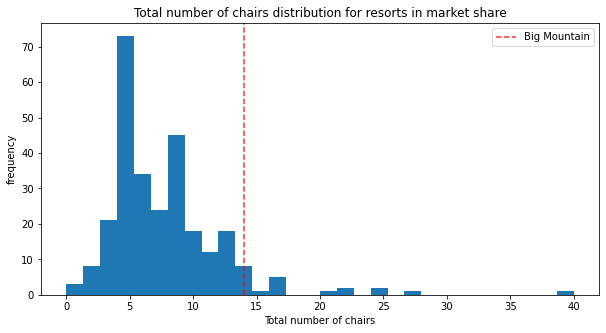

In [52]:
plot_compare('total_chairs', 'Total number of chairs')

In [53]:
# def on the high end of the normal range. beyond this are freak outliers

In [ ]:
#so now we're starting to get an idea of why it scored so high / why it was told to charge such a premium--
#cuz it did so well in the most important categories!!
#that's what we're doing here! we saw what categories were important and we made a function to quickly see how well
#BM did in all of them!
#I'm sure we could set it up so that we can just make a list of these like 8 features and define a plot grid of like
#4x2 and pass the list to it to make one plot for each feature

#also though, since Montana is a tough league/division, we should see how the REST OF MONTANA did w/ price predictions
#based on their performance in important categories / weight scores / score weights!

Big Mountain has amongst the highest number of total chairs, resorts with more appear to be outliers.

### 5.8.5 Fast quads<a id='5.8.5_Fast_quads'></a>

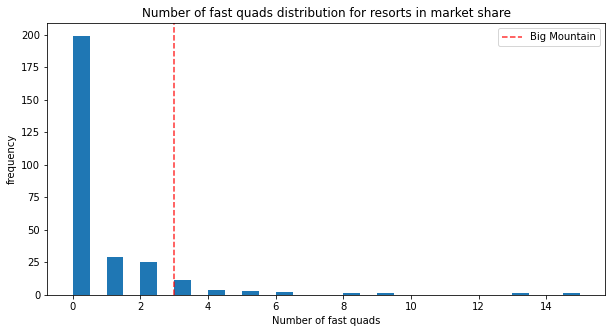

In [54]:
plot_compare('fastQuads', 'Number of fast quads')

In [ ]:
# okay that's good, def ahead of most

# and remem, the weights are in order as laid out earlier, which we found in unit 4 w/ the COEFS!
# remem, these coeffs are according to the LINEAR REGRESSION model! the random forest model ranking IMPORTANCE / 
# best estimators are basically the same features but in a different order/weight proportions (on the right side)
# and note the one we're going w/, for some reason, based on the list/order they provided above and reproduced here
# on the left below, is based on LINEAR REGRESSION, although i thought RANDOM FOREST/rf was better and that's what we
# went w/ in the end as our 'best model'. but i guess since the top features, regardless of order, were essentially the
# same, it doesn't matter so much, the point here is to simply explore the histogram/distribution / where-BM-stands
# in the ranks amongst the population

# LINEAR REGRESSION/lr                   # RANDOM FOREST/rf (NOTE: All feature importances together add up to 1!!)
# vertical_drop        10.767857         # fast_Quads .26
# Snow Making_ac        6.290074         # Runs       .25
# total_chairs          5.794156         # Snow Making.11
# fastQuads             5.745626         # vert drop  .09
# Runs                  5.370555         # skiable ter.03
# LongestRun_mi         0.181814         # tot chairs .02
# trams                -4.142024         # days open. .02
# SkiableTerrain_ac    -5.249780         # daysopstrat.02

#okay, i guess i could see why the lr ones are better to go w/, cuz of end
#but at same time, what's up w/ the negatives that early on??

Most resorts have no fast quads. Big Mountain has 3, which puts it high up that league table. There are some values  much higher, but they are rare.

In [ ]:
#oh yeah wow just realized most don't have any! that's what that big bar is - it's not 1!

### 5.8.6 Runs<a id='5.8.6_Runs'></a>

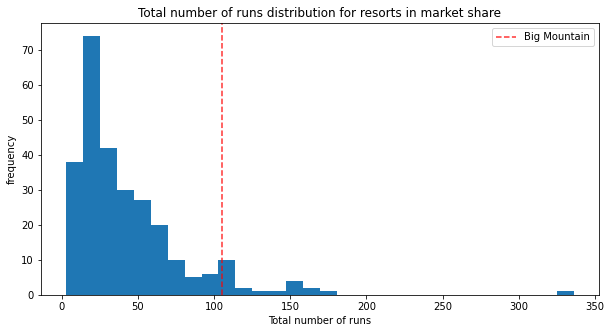

In [23]:
plot_compare('Runs', 'Total number of runs')

Big Mountain compares well for the number of runs. There are some resorts with more, but not many.

### 5.8.7 Longest run<a id='5.8.7_Longest_run'></a>

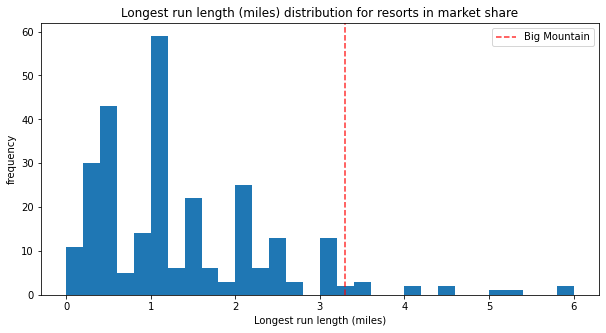

In [24]:
plot_compare('LongestRun_mi', 'Longest run length (miles)')

Big Mountain has one of the longest runs. Although it is just over half the length of the longest, the longer ones are rare.

### 5.8.8 Trams<a id='5.8.8_Trams'></a>

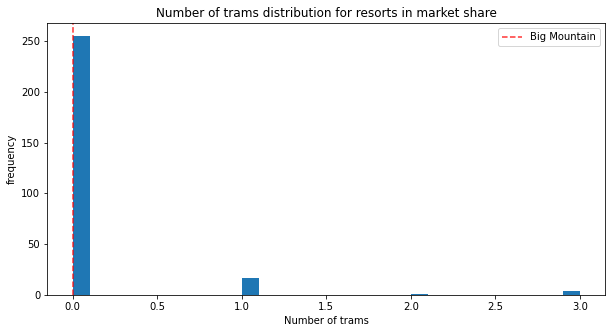

In [25]:
plot_compare('trams', 'Number of trams')

The vast majority of resorts, such as Big Mountain, have no trams.

### 5.8.9 Skiable terrain area<a id='5.8.9_Skiable_terrain_area'></a>

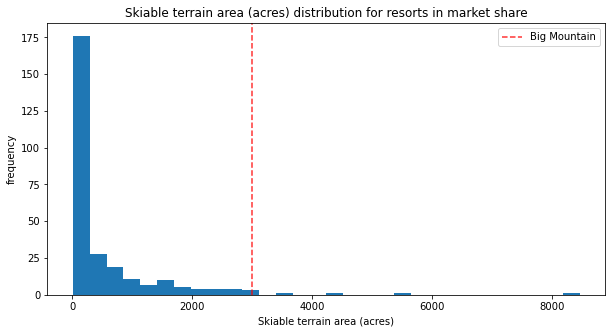

In [26]:
plot_compare('SkiableTerrain_ac', 'Skiable terrain area (acres)')

Big Mountain is amongst the resorts with the largest amount of skiable terrain.

## 5.9 Modeling scenarios<a id='5.9_Modeling_scenarios'></a>

Big Mountain Resort has been reviewing potential scenarios for either cutting costs or increasing revenue (from ticket prices). Ticket price is not determined by any set of parameters; the resort is free to set whatever price it likes. However, the resort operates within a market where people pay more for certain facilities, and less for others. Being able to sense how facilities support a given ticket price is valuable business intelligence. This is where the utility of our model comes in.

The business has shortlisted some options:
1. Permanently closing down up to 10 of the least used runs. This doesn't impact any other resort statistics.
2. Increase the vertical drop by adding a run to a point 150 feet lower down but requiring the installation of an additional chair lift to bring skiers back up, without additional snow making coverage
3. Same as number 2, but adding 2 acres of snow making cover
4. Increase the longest run by 0.2 mile to boast 3.5 miles length, requiring an additional snow making coverage of 4 acres

The expected number of visitors over the season is 350,000 and, on average, visitors ski for five days. Assume the provided data includes the additional lift that Big Mountain recently installed.

In [27]:
expected_visitors = 350_000

In [28]:
all_feats = ['vertical_drop', 'Snow Making_ac', 'total_chairs', 'fastQuads', 
             'Runs', 'LongestRun_mi', 'trams', 'SkiableTerrain_ac']
big_mountain[all_feats]

,vertical_drop,Snow Making_ac,total_chairs,fastQuads,Runs,LongestRun_mi,trams,SkiableTerrain_ac
124,2353,600.0,14,3,105.0,3.3,0,3000.0


In [ ]:
#Code task 2#
#In this function, copy the Big Mountain data into a new data frame
#(Note we use .copy()!)
#And then for each feature, and each of its deltas (changes from the original),
#create the modified scenario dataframe (bm2) and make a ticket price prediction
#for it. The difference between the scenario's prediction and the current
#prediction is then calculated and returned.
#Complete the code to increment each feature by the associated delta
def predict_increase(features, deltas):
    """Increase in modelled ticket price by applying delta to feature.
    
    Arguments:
    features - list, names of the features in the ski_data dataframe to change
    deltas - list, the amounts by which to increase the values of the features
    
    Outputs:
    Amount of increase in the predicted ticket price
    """
    
    bm2 = X_bm.copy()
    for f, d in zip(features, deltas):
        bm2[___] += ___
    return model.predict(bm2).item() - model.predict(X_bm).item()

### 5.9.1 Scenario 1<a id='5.9.1_Scenario_1'></a>

Close up to 10 of the least used runs. The number of runs is the only parameter varying.

In [30]:
[i for i in range(-1, -11, -1)]

[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10]

In [31]:
runs_delta = [i for i in range(-1, -11, -1)]
price_deltas = [predict_increase(['Runs'], [delta]) for delta in runs_delta]

In [32]:
price_deltas

[0.0,
 -0.4057971014492807,
 -0.6666666666666714,
 -0.6666666666666714,
 -0.6666666666666714,
 -1.2608695652173907,
 -1.2608695652173907,
 -1.2608695652173907,
 -1.7101449275362341,
 -1.8115942028985472]

In [ ]:
#Code task 3#
#Create two plots, side by side, for the predicted ticket price change (delta) for each
#condition (number of runs closed) in the scenario and the associated predicted revenue
#change on the assumption that each of the expected visitors buys 5 tickets
#There are two things to do here:
#1 - use a list comprehension to create a list of the number of runs closed from `runs_delta`
#2 - use a list comprehension to create a list of predicted revenue changes from `price_deltas`
runs_closed = [-1 * ___ for ___ in runs_delta] #1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax[0].plot(runs_closed, price_deltas, 'o-')
ax[0].set(xlabel='Runs closed', ylabel='Change ($)', title='Ticket price')
revenue_deltas = [5 * expected_visitors * ___ for ___ in ___] #2
ax[1].plot(runs_closed, revenue_deltas, 'o-')
ax[1].set(xlabel='Runs closed', ylabel='Change ($)', title='Revenue');

The model says closing one run makes no difference. Closing 2 and 3 successively reduces support for ticket price and so revenue. If Big Mountain closes down 3 runs, it seems they may as well close down 4 or 5 as there's no further loss in ticket price. Increasing the closures down to 6 or more leads to a large drop. 

### 5.9.2 Scenario 2<a id='5.9.2_Scenario_2'></a>

In this scenario, Big Mountain is adding a run, increasing the vertical drop by 150 feet, and installing an additional chair lift.

In [ ]:
#Code task 4#
#Call `predict_increase` with a list of the features 'Runs', 'vertical_drop', and 'total_chairs'
#and associated deltas of 1, 150, and 1
ticket2_increase = ___(['Runs', ___, ___], [1, ___, ___])
revenue2_increase = 5 * expected_visitors * ticket2_increase

In [35]:
print(f'This scenario increases support for ticket price by ${ticket2_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue2_increase:.0f}')

This scenario increases support for ticket price by $1.99
Over the season, this could be expected to amount to $3474638


### 5.9.3 Scenario 3<a id='5.9.3_Scenario_3'></a>

In this scenario, you are repeating the previous one but adding 2 acres of snow making.

In [ ]:
#Code task 5#
#Repeat scenario 2 conditions, but add an increase of 2 to `Snow Making_ac`
ticket3_increase = predict_increase(['Runs', 'vertical_drop', 'total_chairs', ___], [1, 150, 1, ___])
revenue3_increase = 5 * expected_visitors * ticket3_increase

In [37]:
print(f'This scenario increases support for ticket price by ${ticket3_increase:.2f}')
print(f'Over the season, this could be expected to amount to ${revenue3_increase:.0f}')

This scenario increases support for ticket price by $1.99
Over the season, this could be expected to amount to $3474638


Such a small increase in the snow making area makes no difference!

### 5.9.4 Scenario 4<a id='5.9.4_Scenario_4'></a>

This scenario calls for increasing the longest run by .2 miles and guaranteeing its snow coverage by adding 4 acres of snow making capability.

In [ ]:
#Code task 6#
#Predict the increase from adding 0.2 miles to `LongestRun_mi` and 4 to `Snow Making_ac`
predict_increase([___, ___], [___, ___])

No difference whatsoever. Although the longest run feature was used in the linear model, the random forest model (the one we chose because of its better performance) only has longest run way down in the feature importance list. 

## 5.10 Summary<a id='5.10_Summary'></a>

**Q: 1** Write a summary of the results of modeling these scenarios. Start by starting the current position; how much does Big Mountain currently charge? What does your modelling suggest for a ticket price that could be supported in the marketplace by Big Mountain's facilities? How would you approach suggesting such a change to the business leadership? Discuss the additional operating cost of the new chair lift per ticket (on the basis of each visitor on average buying 5 day tickets) in the context of raising prices to cover this. For future improvements, state which, if any, of the modeled scenarios you'd recommend for further consideration. Suggest how the business might test, and progress, with any run closures.

**A: 1** Your answer here

## 5.11 Further work<a id='5.11_Further_work'></a>

**Q: 2** What next? Highlight any deficiencies in the data that hampered or limited this work. The only price data in our dataset were ticket prices. You were provided with information about the additional operating cost of the new chair lift, but what other cost information would be useful? Big Mountain was already fairly high on some of the league charts of facilities offered, but why was its modeled price so much higher than its current price? Would this mismatch come as a surprise to the business executives? How would you find out? Assuming the business leaders felt this model was useful, how would the business make use of it? Would you expect them to come to you every time they wanted to test a new combination of parameters in a scenario? We hope you would have better things to do, so how might this model be made available for business analysts to use and explore?

**A: 2** Your answer here